In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

#read the data
df_book = pd.read_excel('/content/drive/MyDrive/Book4.xlsx', index_col = False)
df_book.head()

,VariantID,Variant_Change,Mono_Identity,DateTimeCreated,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),CycleTime (s),Downtime (s),ShutDown (s),Shift,Shift Status
0,28,2,2,2021-07-08 07:33:38.747,0,0,0,0,123,0,0,0,1,1
1,28,1,2,2021-07-08 07:46:45.343,1574,1218,896,510,186,511,449,0,1,0
2,28,1,2,2021-07-08 07:48:58.927,205,167,187,36,127,35,0,0,1,0
3,28,1,2,2021-07-08 07:49:31.807,94,128,69,35,128,35,0,0,1,0
4,28,1,2,2021-07-08 07:50:06.607,103,70,70,37,130,37,0,0,1,0


In [3]:
df_book.shape

(26959, 14)

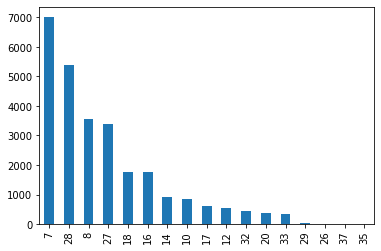

In [4]:
#plotting the value_counts of each varientid
df_book.VariantID.value_counts().plot(kind = 'bar')

In [5]:
#traces library is used to generate timeseries data
!pip install traces
from datetime import datetime, timedelta
import traces

  Created wheel for infinity: filename=infinity-1.5-py3-none-any.whl size=3095 sha256=39930a420ba95d4e18d952f766d4ca2ff2372a78067ae374e75d727e81bdc8d6
  Stored in directory: /root/.cache/pip/wheels/ee/2c/f4/26985d995b1d5930ab73914f76ffccd54b1af31c2e68b507bc
Successfully built infinity


In [6]:
#resamples the data to every 15-mins

def resampling_data(df, start_date, end_date):
    
    #create empty dataframe to store the resampled data
    temp_df = pd.DataFrame({})
    
    #iterate through the columns
    for cols in df.columns:
        
        # create an empty row list which has the date_range
        Row_list =[]
        
        if cols != 'DateTimeCreated':
            
            #iterate through the rows 
            for index, rows in df.iterrows():
                # Create list for the current row
                my_list =[rows.DateTimeCreated, rows[cols]]

                # append the list to the final list
                Row_list.append(my_list)

            #traces library resamples the data in desired order and linearly interpolates it
            ts = traces.TimeSeries(Row_list)

            temp = np.array(ts.sample(
            sampling_period = timedelta(minutes=15),
            start=start_date,
            end=end_date,
            interpolate='linear'))
            
            temp_df[cols] = temp[:, 1]
    
    temp_df['DateTimeCreated'] = temp[:, 0]
    
    #drop first 2 rows of the dataframe because it will be none
    temp_df = temp_df.drop([0, 1])

    return temp_df

#gets starting date of each dataframe
def get_start_date(df):
    start_year = df.DateTimeCreated.iloc[0].year
    start_month = df.DateTimeCreated.iloc[0].month
    start_day = df.DateTimeCreated.iloc[0].day
    start_hour = df.DateTimeCreated.iloc[0].hour
    
    return datetime(start_year, start_month, start_day, start_hour)

#gets ending date of each dataframe
def get_end_date(df):
    end_year = df.DateTimeCreated.iloc[-1].year
    end_month = df.DateTimeCreated.iloc[-1].month
    end_day = df.DateTimeCreated.iloc[-1].day
    end_hour = df.DateTimeCreated.iloc[-1].hour
    
    return datetime(end_year, end_month, end_day, end_hour)

In [7]:
#to check the number of variantids 
variants = sorted(df_book.VariantID.unique())
variants = variants[:-2]
print(variants)

[7, 8, 10, 12, 14, 16, 17, 18, 20, 26, 27, 28, 29, 32, 33]


In [8]:
Df_Final = pd.DataFrame()

#loop through the variants and resample 
for vid in variants:
    print(f'variant_id : {vid}')
    sdf = df_book[df_book.VariantID == vid].sort_values(by = 'DateTimeCreated')
    #calls the resampling data function on the date-wise sorted dataframe 
    sdf = resampling_data(sdf, start_date = get_start_date(sdf), end_date = get_end_date(sdf))
    #concat the resampled data to the Df_Final
    Df_Final = pd.concat([Df_Final, sdf])
    print(f'shape of sdf : {sdf.shape} , shape of df_final : {Df_Final.shape}')

#Make DateTimeCreated as the index    
Df_Final.index = Df_Final.DateTimeCreated

variant_id : 7
shape of sdf : (5891, 14) , shape of df_final : (5891, 14)
variant_id : 8
shape of sdf : (5091, 14) , shape of df_final : (10982, 14)
variant_id : 10
shape of sdf : (5363, 14) , shape of df_final : (16345, 14)
variant_id : 12
shape of sdf : (371, 14) , shape of df_final : (16716, 14)
variant_id : 14
shape of sdf : (403, 14) , shape of df_final : (17119, 14)
variant_id : 16
shape of sdf : (5927, 14) , shape of df_final : (23046, 14)
variant_id : 17
shape of sdf : (6407, 14) , shape of df_final : (29453, 14)
variant_id : 18
shape of sdf : (6423, 14) , shape of df_final : (35876, 14)
variant_id : 20
shape of sdf : (343, 14) , shape of df_final : (36219, 14)
variant_id : 26
shape of sdf : (4539, 14) , shape of df_final : (40758, 14)
variant_id : 27
shape of sdf : (7891, 14) , shape of df_final : (48649, 14)
variant_id : 28
shape of sdf : (7991, 14) , shape of df_final : (56640, 14)
variant_id : 29
shape of sdf : (11, 14) , shape of df_final : (56651, 14)
variant_id : 32
shap

In [9]:
Df_Final.to_csv('Dataframe_final_preprocessed.csv', index = False)

## Model Building

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv('Dataframe_final_preprocessed.csv', index_col = False)
df.head()

,VariantID,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),CycleTime (s),Downtime (s),ShutDown (s),Shift,Shift Status,DateTimeCreated
0,7.0,1.963532,2.0,9006.761940,8967.376143,9049.752345,4512.332027,113.963532,502.113312,440.113312,0.0,1.0,0.0,2021-08-05 12:30:00
1,7.0,1.694260,2.0,8347.854285,8298.236166,8412.924963,4197.284231,113.694260,1307.774000,1245.774000,0.0,1.0,0.0,2021-08-05 12:45:00
2,7.0,1.424988,2.0,7688.946630,7629.096190,7776.097581,3882.236435,113.424988,2113.434688,2051.434688,0.0,1.0,0.0,2021-08-05 13:00:00
3,7.0,1.155717,2.0,7030.038976,6959.956213,7139.270199,3567.188640,113.155717,2919.095376,2857.095376,0.0,1.0,0.0,2021-08-05 13:15:00
4,7.0,1.000000,2.0,2189.550768,2179.038080,3619.718997,1864.589761,168.230263,1864.589761,1802.589761,0.0,1.0,0.0,2021-08-05 13:30:00


In [11]:
Cycle_time = df['CycleTime (s)']

In [12]:
#round values and convert to integer except Cycle Time
df.drop(['CycleTime (s)'] , axis = 1, inplace = True)
df = np.round(df)
train_cols = df.drop('DateTimeCreated', axis=1).columns[1:]
df[train_cols] = df[train_cols].fillna("0").astype(int)
df['CycleTime (s)'] = Cycle_time

In [13]:
df.head()

,VariantID,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),Downtime (s),ShutDown (s),Shift,Shift Status,DateTimeCreated,CycleTime (s)
0,7.0,2,2,9007,8967,9050,4512,114,440,0,1,0,2021-08-05 12:30:00,502.113312
1,7.0,2,2,8348,8298,8413,4197,114,1246,0,1,0,2021-08-05 12:45:00,1307.774000
2,7.0,1,2,7689,7629,7776,3882,113,2051,0,1,0,2021-08-05 13:00:00,2113.434688
3,7.0,1,2,7030,6960,7139,3567,113,2857,0,1,0,2021-08-05 13:15:00,2919.095376
4,7.0,1,2,2190,2179,3620,1865,168,1803,0,1,0,2021-08-05 13:30:00,1864.589761


**Now Lets build a model for variantid 7**

In [14]:
df_id7 = df[df.VariantID == 7]

In [15]:
df_id7.columns

Index(['VariantID', 'Variant_Change', 'Mono_Identity', 'Mono_MM_Duration (s)',
       'Wrapping_Duration (s)', 'Pressing_Duration (s)', 'GBD_MM Duration (s)',
       'OperationTime (s)', 'Downtime (s)', 'ShutDown (s)', 'Shift',
       'Shift Status', 'DateTimeCreated', 'CycleTime (s)'],
      dtype='object')

Input_

In [16]:
df_id7.head()

,VariantID,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),Downtime (s),ShutDown (s),Shift,Shift Status,DateTimeCreated,CycleTime (s)
0,7.0,2,2,9007,8967,9050,4512,114,440,0,1,0,2021-08-05 12:30:00,502.113312
1,7.0,2,2,8348,8298,8413,4197,114,1246,0,1,0,2021-08-05 12:45:00,1307.774000
2,7.0,1,2,7689,7629,7776,3882,113,2051,0,1,0,2021-08-05 13:00:00,2113.434688
3,7.0,1,2,7030,6960,7139,3567,113,2857,0,1,0,2021-08-05 13:15:00,2919.095376
4,7.0,1,2,2190,2179,3620,1865,168,1803,0,1,0,2021-08-05 13:30:00,1864.589761


In [17]:
df_id7['Mono_Identity'].value_counts()

2    5891
Name: Mono_Identity, dtype: int64

Remove this row as it is the same value for every observation and doesnt make a difference

In [18]:
df_id7_train = df_id7.drop(['VariantID'], axis = 1)

In [19]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU

In [20]:
from sklearn.preprocessing import MinMaxScaler

Trial Code for 1 column

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [22]:

timeseries_data = df_id7_train['Mono_MM_Duration (s)']

#scaler
scaler = MinMaxScaler()
scaler.fit(np.array(timeseries_data).reshape(-1, 1))
scaled_train = scaler.transform(np.array(timeseries_data).reshape(-1, 1))

n_input = 14 #no.of past observations to give in as input to predict one outcome
n_features = 1 

#Generates data
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 64)

X, y = generator[0]

#creating the Deep_learing model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape = (X.shape[1], X.shape[2]),return_sequences= True))
model.add(LSTM(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

#fiting the model for 5 epochs
model.fit(generator, epochs = 5, verbose = 1)

test_predictions = []

#take sthe scaled batch and get the observations of the last 14 values
first_eval_batch = scaled_train[-n_input:]
#reshape them(1,14,1)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

future = 7
#loops through the length of the days into the future you want to predict, makes predictions and saves them
for i in range(future):
  #gets prediction for current batch
  current_pred = model.predict(current_batch)[0]
  #append to test_predictions
  test_predictions.append(current_pred)  
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

#inverse transform
true_predictions = scaler.inverse_transform(test_predictions)
#flatten the list
true_predictions = true_predictions.flatten()

Epoch 1/5
92/92 [==============================] - 4s 16ms/step - loss: 0.0100
Epoch 2/5
92/92 [==============================] - 2s 23ms/step - loss: 0.0035
Epoch 3/5
92/92 [==============================] - 2s 16ms/step - loss: 0.0024
Epoch 4/5
92/92 [==============================] - 2s 17ms/step - loss: 0.0022
Epoch 5/5
92/92 [==============================] - 2s 18ms/step - loss: 0.0032


In [23]:
X.shape

(64, 14, 1)

In [24]:
true_predictions

array([4127.38861232, 4133.85514447, 4139.99215536, 4147.50661674,
       4156.8411884 , 4201.4702405 , 4285.42115956])

Make predictions for 7 days for each of the column
**same method and code as used above in the trail cell**

In [25]:
temp_df = pd.DataFrame()
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

for cols in df_id7_train.drop(['CycleTime (s)', 'DateTimeCreated'], axis = 1).columns:

  timeseries_data = df_id7_train[cols]

  scaler = MinMaxScaler()
  print(f'Cols : {cols}')
  scaler.fit(np.array(timeseries_data).reshape(-1, 1))
  scaled_train = scaler.transform(np.array(timeseries_data).reshape(-1, 1))

  n_input = 14
  n_features = 1

  generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size = 64)

  X, y = generator[0]

  model = Sequential()
  model.add(LSTM(64, activation='relu', input_shape = (X.shape[1], X.shape[2]),return_sequences= True))
  model.add(LSTM(32, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer = 'adam', loss = 'mse')

  print(f'Training for columns : {cols}')
  model.fit(generator, epochs = 3, verbose = 1)

  test_predictions = []

  first_eval_batch = scaled_train[-n_input:]
  current_batch = first_eval_batch.reshape((1, n_input, n_features))

  future = 7

  for i in range(future):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
  
  true_predictions = scaler.inverse_transform(test_predictions)
  #flatten the list so that you can save it in the datafarme
  temp_df[cols] = true_predictions.flatten()

Cols : Variant_Change
Training for columns : Variant_Change
Epoch 1/3
92/92 [==============================] - 4s 21ms/step - loss: 0.1001
Epoch 2/3
92/92 [==============================] - 2s 21ms/step - loss: 0.0271
Epoch 3/3
92/92 [==============================] - 2s 23ms/step - loss: 0.0206
Cols : Mono_Identity
Training for columns : Mono_Identity
Epoch 1/3
92/92 [==============================] - 5s 22ms/step - loss: 0.0000e+00
Epoch 2/3
92/92 [==============================] - 2s 22ms/step - loss: 0.0000e+00
Epoch 3/3
92/92 [==============================] - 2s 23ms/step - loss: 0.0000e+00
Cols : Mono_MM_Duration (s)
Training for columns : Mono_MM_Duration (s)
Epoch 1/3
92/92 [==============================] - 5s 23ms/step - loss: 0.0077
Epoch 2/3
92/92 [==============================] - 2s 23ms/step - loss: 0.0031
Epoch 3/3
92/92 [==============================] - 2s 22ms/step - loss: 0.0027
Cols : Wrapping_Duration (s)
Training for columns : Wrapping_Duration (s)
Epoch 1/3
92/

In [26]:
temp_df.tail()

,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),Downtime (s),ShutDown (s),Shift,Shift Status
2,1.109281,2.0,8339.723015,7305.539705,6515.718178,3643.491308,353.969355,1768.670096,1372.439452,1.952898,0.032590
3,1.125112,2.0,8648.232350,7304.528721,6828.509291,3946.111606,359.834965,1791.459451,1427.262955,1.946373,0.035733
4,1.140474,2.0,8993.790028,7305.155101,7201.336748,4298.578785,364.226915,1819.946413,1497.827255,1.938832,0.038850
5,1.155433,2.0,9370.643622,7305.591330,7635.025688,4665.466166,370.722108,1856.877837,1580.736586,1.930497,0.041801
6,1.170859,2.0,9773.394318,7305.833966,8110.241717,5036.311594,376.295464,1906.869450,1673.013739,1.921562,0.044516


In [27]:
temp_df = temp_df.round()
temp_df = abs(temp_df)
df_id7_forecasted = temp_df.astype(int)

In [28]:
df_id7_forecasted['CycleTime (s)'] = np.zeros(7)

In [29]:
df_id7_train

,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),Downtime (s),ShutDown (s),Shift,Shift Status,DateTimeCreated,CycleTime (s)
0,2,2,9007,8967,9050,4512,114,440,0,1,0,2021-08-05 12:30:00,502.113312
1,2,2,8348,8298,8413,4197,114,1246,0,1,0,2021-08-05 12:45:00,1307.774000
2,1,2,7689,7629,7776,3882,113,2051,0,1,0,2021-08-05 13:00:00,2113.434688
3,1,2,7030,6960,7139,3567,113,2857,0,1,0,2021-08-05 13:15:00,2919.095376
4,1,2,2190,2179,3620,1865,168,1803,0,1,0,2021-08-05 13:30:00,1864.589761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5886,1,2,79,166,406,36,131,0,0,2,0,2021-10-05 20:00:00,36.922970
5887,1,2,191,80,85,49,144,0,0,2,0,2021-10-05 20:15:00,49.933628
5888,1,2,148,108,72,38,129,0,0,2,0,2021-10-05 20:30:00,37.275124
5889,1,2,75,87,66,48,144,0,0,2,0,2021-10-05 20:45:00,47.594801


In [30]:
cycle_time_id7 = df_id7_train['CycleTime (s)']
df_id7_train.drop(['CycleTime (s)'], axis = 1, inplace = True)

df_id7_train['CycleTime (s)'] = cycle_time_id7

In [31]:
df_id7_forecasted = pd.concat([df_id7_train, df_id7_forecasted])

In [32]:
df_id7['CycleTime (s)'][:5891]

0        502.113312
1       1307.774000
2       2113.434688
3       2919.095376
4       1864.589761
           ...     
5886      36.922970
5887      49.933628
5888      37.275124
5889      47.594801
5890      76.912360
Name: CycleTime (s), Length: 5891, dtype: float64

In [33]:
df_temp = df_id7_forecasted.copy()

In [34]:
df_id7_forecasted.drop(['DateTimeCreated'], axis = 1, inplace = True)

We forecasted data for each column and we have stored it..

In [35]:
final = df_id7_forecasted.copy()
final['VariantID'] = 7

In [36]:
final.shape

(5898, 13)

**Forecasting CycleTime**

In [37]:
from sklearn.preprocessing import StandardScaler
scaler_std = StandardScaler()
scaler_std = scaler_std.fit(df_id7_forecasted)
df_id7_trainscaled = scaler_std.transform(df_id7_forecasted)

In [38]:
Train_X = []
Train_y = []

n_Future = 1
n_Past = 14

In [39]:
df_id7_train.shape[1]

13

Generates data acoordingly into inputs and output

In [40]:
#iterate between the past observations limit and the length of the df and subtract the future(days to predict into the future) and add 1 
for i in range(n_Past, len(df_id7_trainscaled) - n_Future + 1):
    #append each value to Train_X
    Train_X.append(df_id7_trainscaled[i - n_Past:i, 0:df_id7_train.shape[1]])
    #append CycleTime to the Train_y list [-1] is the col index of Cycletime
    Train_y.append(df_id7_trainscaled[i + n_Future - 1:i + n_Future, -1])

In [41]:
Train_X, Train_y = np.array(Train_X), np.array(Train_y)

Train_X has shape (5864, 21, 13) where 5864 is the number of observations, 21 is the data which goes into the NN for prediction of 1 datapoint

In [42]:
print(f'Train X shape : {Train_X.shape}')
print(f'Train y shape : {Train_y.shape}')

Train X shape : (5884, 14, 12)
Train y shape : (5884, 1)


In [43]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [44]:
#create the DL model
model_id7 = Sequential()
#using relu as the activation
model_id7.add(LSTM(64, activation='relu', input_shape = (Train_X.shape[1], Train_X.shape[2]), return_sequences=True))
model_id7.add(LSTM(32, activation='relu', return_sequences=False))
model_id7.add(Dropout(0.2))
model_id7.add(Dense(Train_y.shape[1]))

#using adam as the activation
model_id7.compile(optimizer = 'adam', loss = 'mse')
model_id7.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 14, 64)            19712     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 32,161
Trainable params: 32,161
Non-trainable params: 0
_________________________________________________________________


In [45]:
history_id7 = model_id7.fit(Train_X, Train_y, 
                    epochs = 10, batch_size = 16,
                    verbose = 1)

Epoch 1/10
368/368 [==============================] - 8s 16ms/step - loss: 0.1260
Epoch 2/10
368/368 [==============================] - 9s 23ms/step - loss: 0.0669
Epoch 3/10
368/368 [==============================] - 11s 31ms/step - loss: 0.0738
Epoch 4/10
368/368 [==============================] - 10s 28ms/step - loss: 0.0557
Epoch 5/10
368/368 [==============================] - 10s 26ms/step - loss: 0.0447
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 0.0491
Epoch 7/10
368/368 [==============================] - 6s 15ms/step - loss: 0.0445
Epoch 8/10
368/368 [==============================] - 6s 15ms/step - loss: 0.0426
Epoch 9/10
368/368 [==============================] - 5s 15ms/step - loss: 0.0444
Epoch 10/10
368/368 [==============================] - 6s 15ms/step - loss: 0.0340


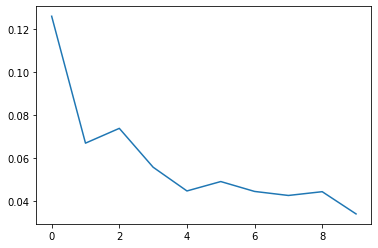

In [46]:
import matplotlib.pyplot as plt
plt.plot(history_id7.history['loss'])

we will create a series of dates to forecast and then append our predictions to it

In [47]:
# we use past data as inputs in order to forecast into the future
N_past = 8
N_future = 7

In [48]:
#create daterage for 7 days into the future
forecast_period_dates = pd.date_range(list(df_id7.DateTimeCreated)[-N_past], periods = N_future, freq = '1d').tolist()
print(forecast_period_dates)

[Timestamp('2021-10-05 19:15:00', freq='D'), Timestamp('2021-10-06 19:15:00', freq='D'), Timestamp('2021-10-07 19:15:00', freq='D'), Timestamp('2021-10-08 19:15:00', freq='D'), Timestamp('2021-10-09 19:15:00', freq='D'), Timestamp('2021-10-10 19:15:00', freq='D'), Timestamp('2021-10-11 19:15:00', freq='D')]


In [49]:
#predict using the observations from the previous data
prediction_id7 = model_id7.predict(Train_X[-N_future:])

In [50]:
#repeat the predictions for the fututre days(given as input)
predictions_id7 = np.repeat(prediction_id7, df_id7_forecasted.shape[1], axis=-1)
#inverse_transform
y_pred_future = scaler_std.inverse_transform(predictions_id7)[:,0]

In [51]:
# Append the predictions to the list
forecast_dates_ID7 = []

for time_i in forecast_period_dates:
    forecast_dates_ID7.append(time_i.date())
    
df_fr_final_ID7 = pd.DataFrame({'Date':np.array(forecast_dates_ID7), 'CycleTime':y_pred_future})
df_fr_final_ID7['Date'] = pd.to_datetime(df_fr_final_ID7['Date'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


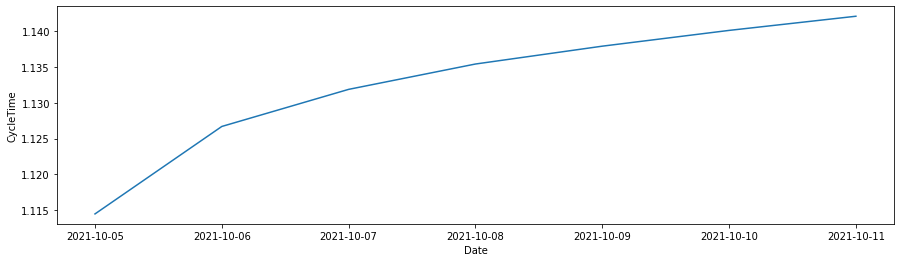

In [52]:
import seaborn as sns

plt.figure(figsize = (15,4))
ax = sns.lineplot(df_fr_final_ID7['Date'], df_fr_final_ID7['CycleTime'])

In [53]:
#plug the cycletime values into the dataframe
df_id7_forecasted['CycleTime (s)'][-7:] = df_fr_final_ID7['CycleTime']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
df_id7_forecasted = df_id7

In [55]:
#converted Values to string
df_id7_forecasted['Variant_Change'] = df_id7_forecasted['Variant_Change'].apply(str)
df_id7_forecasted['Mono_Identity'] = df_id7_forecasted['Mono_Identity'].apply(str)
df_id7_forecasted['Shift'] = df_id7_forecasted['Shift'].apply(str)
df_id7_forecasted['Shift Status'] = df_id7_forecasted['Shift Status'].apply(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

## Now We will do the same for other VarientIDs too

we will forecast for top 5 variantIDs with more data

In [56]:
idx = df.VariantID.value_counts().index
top_five_vid = idx[:5].tolist()
top_five_vid

[28.0, 27.0, 18.0, 17.0, 16.0]

In [57]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from warnings import filterwarnings as filt 

filt('ignore')

Function to generate the dataframe with predicted values

In [58]:
# main function which takes dataframe as arguement and the vid which you want to forecast
def get_forecasted_df(df, vid):
  sdf = df[df.VariantID == vid]
  print(sdf.shape)

  if len(sdf) == 0:
    return None

  df_with_datetime = sdf.copy()
  sdf = sdf.drop(['DateTimeCreated', 'VariantID'], axis = 1)
  cols = sdf.drop(['CycleTime (s)'], axis = 1).columns
  sdf[cols] = np.round(sdf[cols])

  "Removing cycleTime and appending it at the last"

  cycle_time = sdf['CycleTime (s)']
  sdf.drop(['CycleTime (s)'], axis = 1, inplace = True)
  sdf['CycleTime (s)'] = cycle_time
  #calls the return_var_forecast functions which returns the forecasted variables df
  sdf_var_forecasted = return_var_forecast(sdf)
  sdf_var_forecasted['CycleTime (s)'] = np.zeros(7)

  #concats the df into one
  df_forecasted = pd.concat([sdf, sdf_var_forecasted])
  df_forecasted[cols] = abs(df_forecasted[cols])
  #calls the function which returns the finals cycletime forecast
  final_forecasted_df = final_Cycle_time_forecasting(df_forecasted, df_with_datetime)

  idx = min(len(final_forecasted_df), 7)

  df_forecasted['CycleTime (s)'][-idx:] = final_forecasted_df.CycleTime 
  df_final = df_forecasted
  df_final['Variant_Change'] = df_final['Variant_Change'].apply(str)
  df_final['Mono_Identity'] = df_final['Mono_Identity'].apply(str)
  df_final['Shift'] = df_final['Shift'].apply(str)
  df_final['Shift Status'] = df_final['Shift Status'].apply(str)

  return df_final

In [59]:
#returns the forecasted variables

def return_var_forecast(df):
  temp_df = pd.DataFrame()
  
  for cols in df.columns:
    print(f'Forecasting for variable : {cols}')
    if cols != 'CycleTime (s)':
      
      timeseries_data = df[cols]

      #scaler
      scaler = MinMaxScaler()
      scaler.fit(np.array(timeseries_data).reshape(-1, 1))
      scaled_train = scaler.transform(np.array(timeseries_data).reshape(-1, 1))

      
      n_input = 14 #past days to consider for predicting
      n_features = 1 #value you are going to predict

      if len(df) < n_input:
        n_input = len(df) - 1

      generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size = 64)

      X, y = generator[0]

      model = Sequential()
      model.add(LSTM(64, activation='relu', input_shape = (X.shape[1], X.shape[2]),return_sequences= True))
      model.add(LSTM(32, activation='relu'))
      model.add(Dense(1))
      model.compile(optimizer = 'adam', loss = 'mse')

      print(f'Training for columns : {cols}')
      model.fit(generator, epochs = 3, verbose = 1)

      #saves predictions into this list
      test_predictions = []

      first_eval_batch = scaled_train[-n_input:]
      current_batch = first_eval_batch.reshape((1, n_input, n_features))

      future = 7

      for i in range(future):
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred)

        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
      
      #apply inverse transform as we have used Minmax scaler
      true_predictions = scaler.inverse_transform(test_predictions)
      
      temp_df[cols] = true_predictions.flatten()
  
  temp_df = temp_df.round()
  temp_df = abs(temp_df)
  temp_df = temp_df.astype(int)
  print(temp_df.shape)
  
  return temp_df

In [60]:
#returns the final forecasted Cycletime

def final_Cycle_time_forecasting(df, datetime_df):

  #scaler
  scaler_std = StandardScaler()
  scaler_std = scaler_std.fit(df)
  df_forecasted_final = scaler_std.transform(df)

  Train_X = []
  Train_y = []

  n_Future = 1
  n_Past = 14

  #generating data
  for i in range(n_Past, len(df_forecasted_final) - n_Future + 1):
    Train_X.append(df_forecasted_final[i - n_Past:i, 0:df_forecasted_final.shape[1]])
    Train_y.append(df_forecasted_final[i + n_Future - 1:i + n_Future, -1])

  
  Train_X, Train_y = np.array(Train_X), np.array(Train_y)

  model = Sequential()
  model.add(LSTM(64, activation='relu', input_shape = (Train_X.shape[1], Train_X.shape[2]), return_sequences=True))
  model.add(LSTM(32, activation='relu', return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(Train_y.shape[1]))

  model.compile(optimizer = 'adam', loss = 'mse')
  model.summary()

  history = model.fit(Train_X, Train_y, 
                    epochs = 5, batch_size = 32,
                    verbose = 1)

  N_past = 8
  N_future = 7
  
  forecast_period_dates = pd.date_range(list(datetime_df.DateTimeCreated)[-N_past], periods = N_future, freq = '1d').tolist()
  prediction = model.predict(Train_X[-N_future:])

  predictions = np.repeat(prediction, df_forecasted_final.shape[1], axis=-1)
  y_pred_future = scaler_std.inverse_transform(predictions)[:,0]

  forecast_dates = []

  for time_i in forecast_period_dates:
      forecast_dates.append(time_i.date())
  

  mini = min(len(forecast_dates), len(y_pred_future))
  final_forecasted_df = pd.DataFrame({'Date':forecast_dates[-mini:], 'CycleTime':y_pred_future[-mini:]})

  final_forecasted_df['Date'] = pd.to_datetime(final_forecasted_df['Date'])
  
  return final_forecasted_df

In [61]:
idx = df.VariantID.value_counts().index
top_five_vid = idx[:5].astype(int).tolist()
top_five_vid

[28, 27, 18, 17, 16]

In [62]:
#import df again

In [63]:
df = pd.read_csv('Dataframe_final_preprocessed.csv', index_col = False)

In [ ]:
print(f'Forecasting for varient id : 28'.center(60, ' '))
# to forecast for any varient enter the varientID as the 2nd parameter in the get_forecasted_df() fucntion which takes the resmapled data as the arguement
# returns the forecasted variables(fc_var) and forecasted Cycletime, df_28 in this case
df_28 = get_forecasted_df(df, 28)                        

              Forecasting for varient id : 28               
(7990, 14)
Forecasting for variable : Variant_Change
Training for columns : Variant_Change
Epoch 1/3
125/125 [==============================] - 5s 21ms/step - loss: 0.0850
Epoch 2/3
125/125 [==============================] - 3s 21ms/step - loss: 0.0165
Epoch 3/3
125/125 [==============================] - 3s 21ms/step - loss: 0.0116
Forecasting for variable : Mono_Identity
Training for columns : Mono_Identity
Epoch 1/3
125/125 [==============================] - 5s 21ms/step - loss: 0.0000e+00
Epoch 2/3
125/125 [==============================] - 3s 21ms/step - loss: 0.0000e+00
Epoch 3/3
125/125 [==============================] - 3s 20ms/step - loss: 0.0000e+00
Forecasting for variable : Mono_MM_Duration (s)
Training for columns : Mono_MM_Duration (s)
Epoch 1/3
125/125 [==============================] - 5s 20ms/step - loss: 0.0048
Epoch 2/3
125/125 [==============================] - 3s 20ms/step - loss: 0.0023
Epoch 3/3
125/125 

In [ ]:
temp = df_28.copy()
temp['VariantID'] = 28

final = pd.concat([final, temp])
final.shape

VariantID 27

In [66]:
print(f'Forecasting for varient id : 27'.center(60, ' '))
df_27 = get_forecasted_df(df, 27)

              Forecasting for varient id : 27               
(7891, 14)
Forecasting for variable : Variant_Change
Training for columns : Variant_Change
Epoch 1/3
124/124 [==============================] - 5s 20ms/step - loss: 0.1032
Epoch 2/3
124/124 [==============================] - 3s 20ms/step - loss: 0.0073
Epoch 3/3
124/124 [==============================] - 3s 21ms/step - loss: 0.0065
Forecasting for variable : Mono_Identity
Training for columns : Mono_Identity
Epoch 1/3
124/124 [==============================] - 5s 20ms/step - loss: 0.0000e+00
Epoch 2/3
124/124 [==============================] - 3s 21ms/step - loss: 0.0000e+00
Epoch 3/3
124/124 [==============================] - 3s 20ms/step - loss: 0.0000e+00
Forecasting for variable : Mono_MM_Duration (s)
Training for columns : Mono_MM_Duration (s)
Epoch 1/3
124/124 [==============================] - 5s 20ms/step - loss: 0.0058
Epoch 2/3
124/124 [==============================] - 3s 20ms/step - loss: 0.0014
Epoch 3/3
124/124 

In [67]:
temp = df_27.copy()
temp['VariantID'] = 27

final = pd.concat([final, temp])
final.shape

(21793, 13)

In [68]:
print(f'Forecasting for varient id : 16'.center(60, ' '))
df_16 = get_forecasted_df(df, 16)

              Forecasting for varient id : 16               
(5926, 14)
Forecasting for variable : Variant_Change
Training for columns : Variant_Change
Epoch 1/3
93/93 [==============================] - 4s 21ms/step - loss: 0.0815
Epoch 2/3
93/93 [==============================] - 2s 21ms/step - loss: 0.0083
Epoch 3/3
93/93 [==============================] - 2s 21ms/step - loss: 0.0077
Forecasting for variable : Mono_Identity
Training for columns : Mono_Identity
Epoch 1/3
93/93 [==============================] - 5s 21ms/step - loss: 0.0000e+00
Epoch 2/3
93/93 [==============================] - 2s 21ms/step - loss: 0.0000e+00
Epoch 3/3
93/93 [==============================] - 2s 22ms/step - loss: 0.0000e+00
Forecasting for variable : Mono_MM_Duration (s)
Training for columns : Mono_MM_Duration (s)
Epoch 1/3
93/93 [==============================] - 4s 21ms/step - loss: 0.0055
Epoch 2/3
93/93 [==============================] - 2s 22ms/step - loss: 0.0021
Epoch 3/3
93/93 [=================

In [ ]:
temp = df_16.copy()
temp['VariantID'] = 16

final = pd.concat([final, temp])
final.shape

In [70]:
print(f'Forecasting for varient id : 17'.center(60, ' '))
df_17 = get_forecasted_df(df, 17)

              Forecasting for varient id : 17               
(6407, 14)
Forecasting for variable : Variant_Change
Training for columns : Variant_Change
Epoch 1/3
100/100 [==============================] - 5s 21ms/step - loss: 0.1206
Epoch 2/3
100/100 [==============================] - 2s 22ms/step - loss: 0.0058
Epoch 3/3
100/100 [==============================] - 2s 21ms/step - loss: 0.0052
Forecasting for variable : Mono_Identity
Training for columns : Mono_Identity
Epoch 1/3
100/100 [==============================] - 5s 21ms/step - loss: 0.0000e+00
Epoch 2/3
100/100 [==============================] - 2s 21ms/step - loss: 0.0000e+00
Epoch 3/3
100/100 [==============================] - 2s 21ms/step - loss: 0.0000e+00
Forecasting for variable : Mono_MM_Duration (s)
Training for columns : Mono_MM_Duration (s)
Epoch 1/3
100/100 [==============================] - 4s 21ms/step - loss: 0.0180
Epoch 2/3
100/100 [==============================] - 2s 21ms/step - loss: 0.0055
Epoch 3/3
100/100 

In [71]:
temp = df_17.copy()
temp['VariantID'] = 17

final = pd.concat([final, temp])
final.shape

(34140, 13)

In [72]:
print(f'Forecasting for varient id : 18'.center(60, ' '))
df_18 = get_forecasted_df(df, 18)

              Forecasting for varient id : 18               
(6422, 14)
Forecasting for variable : Variant_Change
Training for columns : Variant_Change
Epoch 1/3
101/101 [==============================] - 4s 21ms/step - loss: 0.2113
Epoch 2/3
101/101 [==============================] - 2s 21ms/step - loss: 0.0201
Epoch 3/3
101/101 [==============================] - 2s 21ms/step - loss: 0.0182
Forecasting for variable : Mono_Identity
Training for columns : Mono_Identity
Epoch 1/3
101/101 [==============================] - 4s 21ms/step - loss: 0.0000e+00
Epoch 2/3
101/101 [==============================] - 2s 21ms/step - loss: 0.0000e+00
Epoch 3/3
101/101 [==============================] - 2s 21ms/step - loss: 0.0000e+00
Forecasting for variable : Mono_MM_Duration (s)
Training for columns : Mono_MM_Duration (s)
Epoch 1/3
101/101 [==============================] - 4s 21ms/step - loss: 0.0518
Epoch 2/3
101/101 [==============================] - 2s 21ms/step - loss: 0.0021
Epoch 3/3
101/101 

In [ ]:
temp = df_18.copy()
temp['VariantID'] = 18

final = pd.concat([final, temp])
final.shape

In [ ]:
print(f'Forecasting for varient id : 10'.center(60, ' '))
df_10 = get_forecasted_df(df, 10)

In [75]:
temp = df_10.copy()
temp['VariantID'] = 10

final = pd.concat([final, temp])
final.shape

(45939, 13)

In [ ]:
print(f'Forecasting for varient id : 12'.center(60, ' '))
df_12 = get_forecasted_df(df, 12)

In [ ]:
temp = df_12.copy()
temp['VariantID'] = 12

final = pd.concat([final, temp])
final.shape

In [78]:
print(f'Forecasting for varient id : 14'.center(60, ' '))
df_14 = get_forecasted_df(df, 14)

              Forecasting for varient id : 14               
(403, 14)
Forecasting for variable : Variant_Change
Training for columns : Variant_Change
Epoch 1/3
7/7 [==============================] - 2s 19ms/step - loss: 0.4038
Epoch 2/3
7/7 [==============================] - 0s 20ms/step - loss: 0.3379
Epoch 3/3
7/7 [==============================] - 0s 20ms/step - loss: 0.2792
Forecasting for variable : Mono_Identity
Training for columns : Mono_Identity
Epoch 1/3
7/7 [==============================] - 3s 21ms/step - loss: 0.0000e+00
Epoch 2/3
7/7 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 3/3
7/7 [==============================] - 0s 21ms/step - loss: 0.0000e+00
Forecasting for variable : Mono_MM_Duration (s)
Training for columns : Mono_MM_Duration (s)
Epoch 1/3
7/7 [==============================] - 2s 20ms/step - loss: 0.2371
Epoch 2/3
7/7 [==============================] - 0s 20ms/step - loss: 0.1657
Epoch 3/3
7/7 [==============================] - 0s

In [ ]:
temp = df_14.copy()
temp['VariantID'] = 14

final = pd.concat([final, temp])
final.shape

In [ ]:
print(f'Forecasting for varient id : 20'.center(60, ' '))
df_20 = get_forecasted_df(df, 20)

In [ ]:
temp = df_20.copy()
temp['VariantID'] = 20

final = pd.concat([final, temp])
final.shape

In [ ]:
print(f'Forecasting for varient id : 26'.center(60, ' '))
df_26 = get_forecasted_df(df, 26)

In [83]:
temp = df_26.copy()
temp['VariantID'] = 26

final = pd.concat([final, temp])
final.shape

(51620, 13)

In [ ]:
print(f'Forecasting for varient id : 29'.center(60, ' '))
df_29 = get_forecasted_df(df, 29)

In [ ]:
temp = df_29.copy()
temp['VariantID'] = 29

final = pd.concat([final, temp])
final.shape

In [ ]:
print(f'Forecasting for varient id : 32'.center(60, ' '))
df_32 = get_forecasted_df(df, 32)

In [ ]:
temp = df_32.copy()
temp['VariantID'] = 32

final = pd.concat([final, temp])
final.shape

In [88]:
print(f'Forecasting for varient id : 33'.center(60, ' '))
df_33 = get_forecasted_df(df, 33)          

              Forecasting for varient id : 33               
(2787, 14)
Forecasting for variable : Variant_Change
Training for columns : Variant_Change
Epoch 1/3
44/44 [==============================] - 3s 21ms/step - loss: 0.3191
Epoch 2/3
44/44 [==============================] - 1s 21ms/step - loss: 0.0112
Epoch 3/3
44/44 [==============================] - 1s 21ms/step - loss: 0.0062
Forecasting for variable : Mono_Identity
Training for columns : Mono_Identity
Epoch 1/3
44/44 [==============================] - 3s 21ms/step - loss: 0.0000e+00
Epoch 2/3
44/44 [==============================] - 1s 21ms/step - loss: 0.0000e+00
Epoch 3/3
44/44 [==============================] - 1s 22ms/step - loss: 0.0000e+00
Forecasting for variable : Mono_MM_Duration (s)
Training for columns : Mono_MM_Duration (s)
Epoch 1/3
44/44 [==============================] - 3s 21ms/step - loss: 0.0236
Epoch 2/3
44/44 [==============================] - 1s 22ms/step - loss: 0.0026
Epoch 3/3
44/44 [=================

In [ ]:
temp = df_33.copy()
temp['VariantID'] = 33

final = pd.concat([final, temp])
final.shape

In [ ]:
print(f'Forecasting for varient id : 35'.center(60, ' '))
df_35 = get_forecasted_df(df, 35)

if df_35 != None:
  temp = df_35.copy()
  temp['VariantID'] = 35

  final = pd.concat([final, temp])
  final.shape

In [ ]:
print(f'Forecasting for varient id : 37'.center(60, ' '))
df_37 = get_forecasted_df(df, 37)

if df_37 != None:
  temp = df_37.copy()
  temp['VariantID'] = 37

  final = pd.concat([final, temp])
  final.shape

## Loss comparison between truth and predicted

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataframe_final_preprocessed.csv', index_col = False)
df.head()

In [ ]:
df.info()

In [ ]:
df['VariantID'].value_counts()

**Performing this for variantID 8**

In [95]:
df_8 = df[df.VariantID == 8]

In [96]:
df_8.head()

,DateTimeCreated,VariantID,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),CycleTime (s),Downtime (s),ShutDown (s),Shift,Shift Status
5892,2021-08-13 09:45:00,8.0,1.43555,2.0,69589.176956,69588.114548,69624.061615,28965.364301,115.306649,28963.670950,28901.670950,28213.606094,1.0,0.43555
5893,2021-08-13 10:00:00,8.0,1.00000,2.0,702.415014,724.910587,669.971318,334.933782,114.000000,334.985659,272.985659,0.000000,1.0,0.00000
5894,2021-08-13 10:15:00,8.0,1.00000,2.0,594.465736,601.318696,607.113773,318.775117,127.006653,317.300732,255.300732,0.000000,1.0,0.00000
5895,2021-08-13 10:30:00,8.0,1.00000,2.0,43.824603,260.758490,340.517883,94.732840,199.905889,95.303107,48.130058,0.000000,1.0,0.00000
5896,2021-08-13 10:45:00,8.0,1.00000,2.0,663.750635,846.610856,71.000000,140.692779,756.492150,142.357303,83.488414,0.000000,1.0,0.00000


In [97]:
df_8_top = df_8.copy()

In [98]:
Cycle_time_8 =  df_8['CycleTime (s)']
df_8.drop(['CycleTime (s)', 'DateTimeCreated'], axis = 1, inplace = True)
df_8.Variant_Change = np.round(df_8.Variant_Change)
df_8 = df_8.astype(int)
df_8['Cycle_Time'] = Cycle_time_8

In [99]:
df_8.head()

,VariantID,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),Downtime (s),ShutDown (s),Shift,Shift Status,Cycle_Time
5892,8,1,2,69589,69588,69624,28965,115,28901,28213,1,0,28963.670950
5893,8,1,2,702,724,669,334,114,272,0,1,0,334.985659
5894,8,1,2,594,601,607,318,127,255,0,1,0,317.300732
5895,8,1,2,43,260,340,94,199,48,0,1,0,95.303107
5896,8,1,2,663,846,71,140,756,83,0,1,0,142.357303


In [100]:
#dropping variantID because its the same value
df_8.drop(['VariantID'], axis = 1, inplace = True)

The following is the number of time-steps that we will shift the target-data. Our data-set is resampled to have an observation for every 15 mins, so there are 96 observations for 24 hours.

If we want to predict the weather 24 hours into the future, we shift the data 96 time-steps. If we want to predict the weather 7 days into the future, we shift the data 7 * 96 time-steps.

In [101]:
def Shift(shift_days):
    shift_days = shift_days
    shift_steps = shift_days * 96
    
    return shift_days, shift_steps 

In [102]:
shift_days, shift_steps = Shift(7)

In [103]:
shift_days, shift_steps

(7, 672)

In [104]:
df_8_top.index = df_8_top.DateTimeCreated
df_target_8 = df_8_top[['CycleTime (s)']].shift(-shift_steps)

In [105]:
df_target_8.shape

(5090, 1)

In [106]:
df_target_8.head()

,CycleTime (s)
DateTimeCreated,
2021-08-13 09:45:00,787.688284
2021-08-13 10:00:00,791.905419
2021-08-13 10:15:00,796.122555
2021-08-13 10:30:00,800.339690
2021-08-13 10:45:00,804.556826


In [107]:
df_target_8.tail()

,CycleTime (s)
DateTimeCreated,
2021-10-05 09:00:00,NaN
2021-10-05 09:15:00,NaN
2021-10-05 09:30:00,NaN
2021-10-05 09:45:00,NaN
2021-10-05 10:00:00,NaN


The time-shifted data-frame has the same length as the original data-frame, but the last observations are NaN (not a number) because the data has been shifted backwards so we are trying to shift data that does not exist in the original data-frame.

### input

In [108]:
df_8.head()

,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),Downtime (s),ShutDown (s),Shift,Shift Status,Cycle_Time
5892,1,2,69589,69588,69624,28965,115,28901,28213,1,0,28963.670950
5893,1,2,702,724,669,334,114,272,0,1,0,334.985659
5894,1,2,594,601,607,318,127,255,0,1,0,317.300732
5895,1,2,43,260,340,94,199,48,0,1,0,95.303107
5896,1,2,663,846,71,140,756,83,0,1,0,142.357303


In [109]:
#change datetimecreated to index
df_8.index = df_8_top['DateTimeCreated']

In [110]:
#get train values till the shift steps specified
X_data = df_8.values[0:-shift_steps]

In [111]:
print(type(X_data))
print('Shape: ', X_data.shape)

<class 'numpy.ndarray'>
Shape:  (4418, 12)


In [112]:
y_data = df_target_8.values[:-shift_steps]
print(type(y_data))
print('Shape: ', y_data.shape)

<class 'numpy.ndarray'>
Shape:  (4418, 1)


### split the data

In [113]:
num_data = len(X_data)
train_split = 0.9

num_train = int(num_data * train_split)
print('train samples : ', num_train)

num_test = int(num_data - num_train)
print('test samples : ', num_test)

train samples :  3976
test samples :  442


In [114]:
X_train = X_data[:num_train]
X_test = X_data[num_train:]

print(f'X_train_shape : {X_train.shape}, X_test_shape : {X_test.shape}')

X_train_shape : (3976, 12), X_test_shape : (442, 12)


In [115]:
y_train = y_data[0: num_train]
y_test = y_data[num_train: ]

print(f'y_train_shape : {y_train.shape}, y_test_shape : {y_test.shape}')

y_train_shape : (3976, 1), y_test_shape : (442, 1)


### Lets scale the data

In [116]:
print("Min: ", np.min(X_train))
print("Max: ", np.max(X_train))

Min:  0.0
Max:  499934.0


In [117]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = scaler.fit_transform(X_train)

In [118]:
print("Min: ", np.min(X_train_scaled))
print("Max: ", np.max(X_train_scaled))

Min:  0.0
Max:  1.0000000000000002


In [119]:
X_test_scaled = scaler.transform(X_test)

In [120]:
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [121]:
print("Min: ", np.min(y_train_scaled))
print("Max: ", np.max(y_train_scaled))

Min:  0.0
Max:  1.0000000000000002


### Data Generator

`The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has almost 5k observations, consisting of 13 input-signals and 1 output-signal.`

In [122]:
num_x_signals = X_data.shape[1]
num_y_signals = y_data.shape[1]

#features      prediction     
num_x_signals, num_y_signals

(12, 1)

In [123]:
print(X_train_scaled.shape)
print(y_train_scaled.shape)

(3976, 12)
(3976, 1)


In [124]:
def batch_generator(batch_size, sequence_len):
    
    while True:
        
        X_shape = (batch_size, sequence_len, num_x_signals)
        X_batch = np.zeros(shape = X_shape, dtype = np.float16)
        
        y_shape = (batch_size, sequence_len, num_y_signals)
        y_batch = np.zeros(shape = y_shape, dtype = np.float16)
        
        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_len)
        
            X_batch[i] = X_train_scaled[idx: idx+sequence_len]
            y_batch[i] = y_train_scaled[idx: idx+sequence_len]
            
        yield (X_batch, y_batch)

In [125]:
batch_size = 128
sequence_len = (96 * 7) * 2
sequence_len

1344

We will use a sequence-length of 1344, which means that each random sequence contains observations for 2 weeks. 4 time-steps corresponds to one hour, so 96 x 7 time-steps corresponds to a week, and 96 x 7 x 8 corresponds to 2 weeks.

In [126]:
generator = batch_generator(batch_size = batch_size, 
                            sequence_len = sequence_len)

In [127]:
X_batch, y_batch = next(generator)

In [128]:
X_batch.shape, y_batch.shape

((128, 1344, 12), (128, 1344, 1))

### Validation Set

We will monitor the model's performance on the test-set.
The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [129]:
validation_data = (np.expand_dims(X_test_scaled, axis = 0),
                  np.expand_dims(y_test_scaled, axis = 0))

In [130]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [131]:
model = keras.Sequential([
    keras.layers.LSTM(units = 32,
                     return_sequences = True,
                     input_shape = (None, num_x_signals)),
    keras.layers.Dense(num_y_signals)
])

model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_338 (LSTM)             (None, None, 32)          5760      
                                                                 
 dense_169 (Dense)           (None, None, 1)           33        
                                                                 
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


In [132]:
%%time
model.fit_generator(generator=generator,
                    epochs = 3,
                    steps_per_epoch = 100,
                    validation_data = validation_data)

Epoch 1/3
100/100 [==============================] - 81s 778ms/step - loss: 0.0462 - val_loss: 0.0224
Epoch 2/3
100/100 [==============================] - 78s 779ms/step - loss: 0.0449 - val_loss: 0.0238
Epoch 3/3
100/100 [==============================] - 78s 781ms/step - loss: 0.0456 - val_loss: 0.0210
CPU times: user 6min 50s, sys: 18.8 s, total: 7min 8s
Wall time: 4min 24s


In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['val_loss'])

**The loss on the validation set is low and its good, there is a steady decrease for each epoch**

In [ ]:

result = model.evaluate(x = np.expand_dims(X_test_scaled, axis = 0),
                        y = np.expand_dims(y_test_scaled, axis = 0))

**Loss on Test-Set**

In [ ]:
print('loss-test-set: ', result)

**Predictions**

In [ ]:
X_test_expanded = np.expand_dims(X_test_scaled, axis = 0)
y_preds = model.predict(X_test_expanded)

In [ ]:
#perform inverse transform
y_pred_rescaled = scaler.inverse_transform(y_preds[0])

**truth and prediction plots**

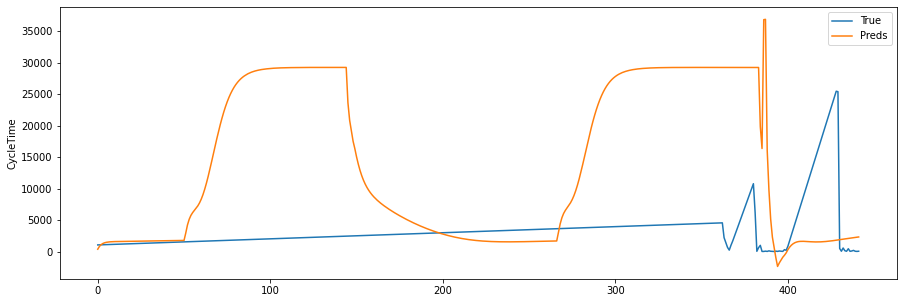

In [138]:
plt.figure(figsize=(15,5))
        
plt.plot(y_test, label = 'True')
plt.plot(y_pred_rescaled, label = 'Preds')

plt.ylabel('CycleTime')
plt.legend()
plt.show()

**`The Model has got the trend almost right but it struggled a bit in detecting the peaks and dips`**

In [139]:
final.head()

,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),Downtime (s),ShutDown (s),Shift,Shift Status,CycleTime (s),VariantID
0,2,2,9007.0,8967.0,9050.0,4512.0,114.0,440.0,0.0,1,0,502.113312,7
1,2,2,8348.0,8298.0,8413.0,4197.0,114.0,1246.0,0.0,1,0,1307.774000,7
2,1,2,7689.0,7629.0,7776.0,3882.0,113.0,2051.0,0.0,1,0,2113.434688,7
3,1,2,7030.0,6960.0,7139.0,3567.0,113.0,2857.0,0.0,1,0,2919.095376,7
4,1,2,2190.0,2179.0,3620.0,1865.0,168.0,1803.0,0.0,1,0,1864.589761,7


In [140]:
final.tail()

,Variant_Change,Mono_Identity,Mono_MM_Duration (s),Wrapping_Duration (s),Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),Downtime (s),ShutDown (s),Shift,Shift Status,CycleTime (s),VariantID
2,2.0,1.0,1893.0,1958.0,2195.0,1887.0,318.0,2095.0,0.0,1.0,0.0,1.976554,33
3,2.0,1.0,1895.0,1965.0,2229.0,1889.0,318.0,2116.0,0.0,1.0,0.0,1.845570,33
4,2.0,1.0,1897.0,1973.0,2272.0,1891.0,318.0,2141.0,0.0,1.0,0.0,1.748651,33
5,2.0,1.0,1899.0,1983.0,2322.0,1892.0,318.0,2170.0,0.0,1.0,0.0,1.677141,33
6,2.0,1.0,1902.0,1993.0,2380.0,1894.0,319.0,2202.0,0.0,1.0,0.0,1.620570,33


In [141]:
final.shape

(57316, 13)

In [142]:
final.to_csv('forecasted.csv', index=False)